In [6]:
%matplotlib inline

import math
import random

import numpy
import matplotlib.pyplot as plt

dt = 0.001  # simulation time step
t_rc = 0.02  # membrane RC time constant
t_ref = 0.002  # refractory period
t_pstc = 0.1  # post-synaptic time constant
N_A = 50  # number of neurons in first population
N_B = 40  # number of neurons in second population
N_samples = 100  # number of sample points to use when finding decoders
rate_A = 25, 75  # range of maximum firing rates for population A
rate_B = 50, 100  # range of maximum firing rates for population B


def input(t):
    """The input to the system over time"""
    return math.sin(t)


def function(x):
    """The function to compute between A and B."""
    return x 

In [7]:
# create random encoders for the two populations
encoder_A = [random.choice([-1, 1]) for i in range(N_A)]
encoder_B = [random.choice([-1, 1]) for i in range(N_B)]

def generate_gain_and_bias(
        count, intercept_low, intercept_high, rate_low, rate_high):
    gain = []
    bias = []
    for i in range(count):
        # desired intercept (x value for which the neuron starts firing
        intercept = random.uniform(intercept_low, intercept_high)
        # desired maximum rate (firing rate when x is maximum)
        rate = random.uniform(rate_low, rate_high)

        # this algorithm is specific to LIF neurons, but should
        # generate gain and bias values to produce the desired
        # intercept and rate
        z = 1.0 / (1 - math.exp((t_ref - (1.0 / rate)) / t_rc))
        g = (1 - z) / (intercept - 1.0)
        b = 1 - g * intercept
        gain.append(g)
        bias.append(b)
    return gain, bias

gain_A, bias_A = generate_gain_and_bias(N_A, -1, 1, rate_A[0], rate_A[1])
gain_B, bias_B = generate_gain_and_bias(N_B, -1, 1, rate_B[0], rate_B[1])
#print(bias_A)
def run_neurons(input, v, ref):
    """Run the neuron model.

    A simple leaky integrate-and-fire model, scaled so that v=0 is resting
    voltage and v=1 is the firing threshold.
    """
    spikes = []
    for i, _ in enumerate(v):
        dV = dt * (input[i] - v[i]) / t_rc  # the LIF voltage change equation
        v[i] += dV
        if v[i] < 0:
            v[i] = 0  # don't allow voltage to go below 0

        if ref[i] > 0:  # if we are in our refractory period
            v[i] = 0   # keep voltage at zero and
            ref[i] -= dt  # decrease the refractory period

        if v[i] > 1:  # if we have hit threshold
            spikes.append(True)  # spike
            v[i] = 0  # reset the voltage
            ref[i] = t_ref  # and set the refractory period
        else:
            spikes.append(False)
    return spikes

def compute_response(x, encoder, gain, bias, time_limit=0.5):
    """Measure the spike rate of a population for a given value x."""
    N = len(encoder)  # number of neurons
    v = [0] * N  # voltage
    ref = [0] * N  # refractory period

    # compute input corresponding to x
    input = []
    for i in range(N):
        input.append(x * encoder[i] * gain[i] + bias[i])
        v[i] = random.uniform(0, 1)  # randomize the initial voltage level

    count = [0] * N  # spike count for each neuron

    # feed the input into the population for a given amount of time
    t = 0
    while t < time_limit:
        spikes = run_neurons(input, v, ref)
        for i, s in enumerate(spikes):
            if s:
                count[i] += 1
        t += dt
    return [c / time_limit for c in count]  # return the spike rate (in Hz)

def compute_tuning_curves(encoder, gain, bias):
    """Compute the tuning curves for a population"""
    # generate a set of x values to sample at
    x_values = [i * 2.0 / N_samples - 1.0 for i in range(N_samples)]

    # build up a matrix of neural responses to each input (i.e. tuning curves)
    A = []
    for x in x_values:
        response = compute_response(x, encoder, gain, bias)
        A.append(response)
    return x_values, A

def compute_decoder(encoder, gain, bias, function=lambda x: x):
    # get the tuning curves
    x_values, A = compute_tuning_curves(encoder, gain, bias)

    # get the desired decoded value for each sample point
    value = numpy.array([[function(x)] for x in x_values])

    # find the optimal linear decoder
    A = numpy.array(A).T
    Gamma = numpy.dot(A, A.T)
    Upsilon = numpy.dot(A, value)
    Ginv = numpy.linalg.pinv(Gamma)
    decoder = numpy.dot(Ginv, Upsilon) / dt
    return decoder


# find the decoders for A and B
#value of weights at minimal resistance
max_decoder = 100000
#initializing resistance in max resistance state
memristor_A_plus = [2.5*10**8]*len(encoder_A)
memristor_A_minus = [2.5*10**8]*len(encoder_A)

decoder_A_plus = [0.0]*len(encoder_A)
decoder_A_minus = [0.0]*len(encoder_A)
#calculating decoder values based on resistance
for i,s in enumerate(memristor_A_plus):
    decoder_A_plus[i]=100/memristor_A_plus[i]*max_decoder
    decoder_A_minus[i]=100/memristor_A_minus[i]*max_decoder
decoder_A_plus = numpy.transpose([decoder_A_plus])
decoder_A_minus = numpy.transpose([decoder_A_minus])
decoder_A=decoder_A_plus-decoder_A_minus


# compute the weight matrix
decoder_B = compute_decoder(encoder_B, gain_B, bias_B)
weights = numpy.dot(decoder_A, [encoder_B])



In [8]:
v_A = [0.0] * N_A  # voltage for population A
ref_A = [0.0] * N_A  # refractory period for population A
input_A = [0.0] * N_A  # input for population A

v_B = [0.0] * N_B  # voltage for population B
ref_B = [0.0] * N_B  # refractory period for population B
input_B = [0.0] * N_B  # input for population B

#memristor properties
r_min = 100
r_max = 2.5*10**8
voltage = 1
c = -0.128 - 0.522 * voltage

# scaling factor for the post-synaptic filter
pstc_scale = 1.0 - math.exp(-dt / t_pstc)

#learning rate for PES
learning_rate=0.01

# for storing simulation data to plot afterward
inputs = []
times = []
outputs = []
outputs2 = []
ideal = []
errors = []

output = 0.0  # the decoded output value from population B
output_A = 0.0 # the decoded output value from population A
t = 0
n = 0

while t < 30.0:  # noqa: C901 (tell static checker to ignore complexity)
    # call the input function to determine the input value
    x = input(t)

    # convert the input value into an input for each neuron
    for i in range(N_A):
        input_A[i] = x * encoder_A[i] * gain_A[i] + bias_A[i]
    
    # run population A and determine which neurons spike
    spikes_A = run_neurons(input_A, v_A, ref_A)
    
    # decay all of the inputs (implementing the post-synaptic filter)
    for j in range(N_B):
        input_B[j] *= (1.0 - pstc_scale)
    # for each neuron that spikes, increase the input current
    # of all the neurons it is connected to by the synaptic
    # connection weight
    for i, s in enumerate(spikes_A):
        if s:
            for j in range(N_B):
                input_B[j] += weights[i][j] * pstc_scale
    output_A *= (1.0 - pstc_scale)
    for i,s in enumerate(spikes_A):
        if s:
            output_A+=decoder_A[i][0]* pstc_scale
            

    # compute the total input into each neuron in population B
    # (taking into account gain and bias)
    total_B = [0] * N_B
    for j in range(N_B):
        total_B[j] = gain_B[j] * input_B[j] + bias_B[j]

    # run population B and determine which neurons spike
    spikes_B = run_neurons(total_B, v_B, ref_B)

    # for each neuron in B that spikes, update our decoded value
    # (also applying the same post-synaptic filter)
    output *= (1.0 - pstc_scale)
    for j, s in enumerate(spikes_B):
        if s:
            output += decoder_B[j][0] * pstc_scale
            
            
    #calculating error
    error = function(x) - output
    errors.append(error**2)
    #updating resistance values
    for i,s in enumerate(spikes_A):
        if s:
            #for possitive error we lower the resistance of positive memristors if its respective node "fired"
            if error>0:
                n = ((memristor_A_plus[i]-r_min)/r_max)**(1/c)
                n=int(round(n))
                memristor_A_plus[i]=r_min+r_max*(n+1)**c
            #similarly for the negative error update the resistance of negative memristors
            else:
                n = ((memristor_A_minus[i]-r_min)/r_max)**(1/c)
                n=int(round(n))
                memristor_A_minus[i]=r_min+r_max*(n+1)**c
    
    #calculating posisitve and negative components of the decoders based on resistance
    decoder_A_plus = [0.0]*len(encoder_A)
    decoder_A_minus = [0.0]*len(encoder_A)
    for i,s in enumerate(memristor_A_plus):
        decoder_A_plus[i]=100/memristor_A_plus[i]*max_decoder
        decoder_A_minus[i]=100/memristor_A_minus[i]*max_decoder
    decoder_A_plus = numpy.transpose([decoder_A_plus])
    decoder_A_minus = numpy.transpose([decoder_A_minus])
    #calculate final decoders values and calculate weights based on them
    decoder_A=decoder_A_plus-decoder_A_minus
    weights = numpy.dot(decoder_A, [encoder_B])
    
    if t % 5 <= dt:
        print(t, output)
        
    times.append(t)
    inputs.append(x)
    outputs.append(output)
    outputs2.append(output_A)
    ideal.append(function(x))
    t += dt

0 0.0
0.001 0.0
0.5000000000000003 0.11015386183256387
1.0000000000000007 0.32956726892462923
1.5009999999999455 0.6205029767676749
2.0009999999998906 0.8580680097762482
2.5009999999998356 0.6325953851965027
3.0009999999997805 0.2817834899863292
3.5009999999997254 0.059549281052010884
4.000999999999671 -0.14295456934845135
4.500999999999838 -0.3199873444908722
5.000000000000004 -0.4996646104024742
5.500000000000171 -0.5418669506010688
6.000000000000338 -0.3779060666441327
6.500000000000505 -0.030396713835815388
7.000000000000672 0.2807181929897024
7.500000000000839 0.5614245713132189
8.000000000001005 0.8479156209727376
8.500000000000728 0.8467060801183574
9.000000000000451 0.5235082105695696
9.500000000000174 0.0941797201932495
10.000999999999896 -0.23636256383171828
10.50099999999962 -0.5469602460621714
11.000999999999342 -0.8382395715867981
11.500999999999065 -0.9433793261881359
12.000999999998788 -0.5692976307425393
12.50099999999851 -0.23879901061471662
13.000999999998234 0.218314

250000000.0
31681378.66829877


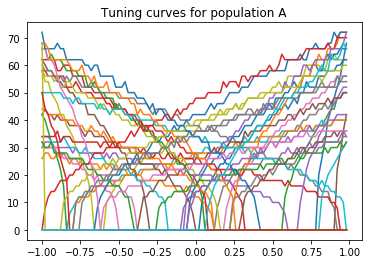

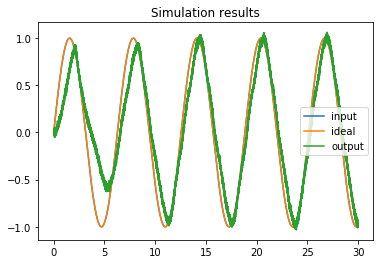

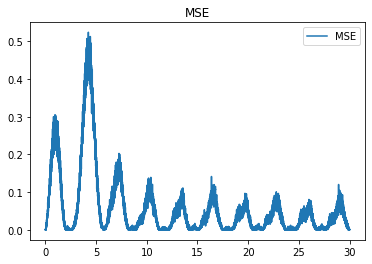

In [9]:
import statistics
x, A = compute_tuning_curves(encoder_A, gain_A, bias_A)


mem_A=max(memristor_A_plus)
print(mem_A)
mem_B=max(memristor_A_minus)
print(mem_B)
plt.figure()
plt.plot(x, A)
plt.title('Tuning curves for population A')


plt.figure()
plt.plot(times, inputs, label='input')
plt.plot(times, ideal, label='ideal')
plt.plot(times, outputs, label='output')
#plt.plot(times, outputs2, label='output_A')
#plt.plot(times, outputs2, label='output_A')
plt.title('Simulation results')
plt.legend()


plt.figure()
plt.plot(times,errors, label='MSE')
plt.title('MSE')
plt.legend()
plt.show()

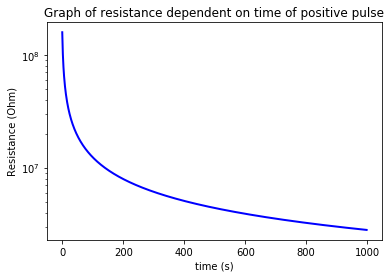

2805146.135754908


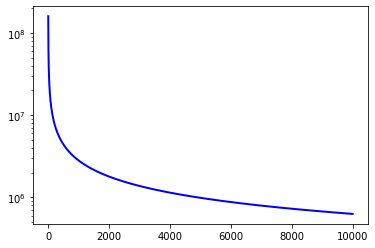

628071.6078773949


In [10]:
from matplotlib import pyplot
r = []
for n in range (1,1000):
    r.append(r_min+r_max*(n+1)**c)


pyplot.plot(r, color='blue', lw=2)
pyplot.yscale('log')
plt.title('Graph of resistance dependent on time of positive pulse')
plt.xlabel('time (s)')
plt.ylabel('Resistance (Ohm)')
pyplot.show()
print(r[998])
r = []
for n in range (1,10000):
    r.append(r_min+r_max*(n+1)**c)


pyplot.plot(r, color='blue', lw=2)
pyplot.yscale('log')
pyplot.show()
print(r[9998])